## Video Analytics

Analyzing video based content requires transforming from one media format (video or audio) to another format (text or numeric) while identifying relevant structure in the resulting format. This multi-media transformation requires machine learning based recognition. Analytics libraries can work on the transformed data to determine the required outcomes including visualizations and charts. The structured data in text or numeric format can also be reused as input to training new machine learning models.

In this notebook we build a simple API to display video in-place from Amazon S3 source, detect text labels based on video contents or visuals, analyze these detected labels by creating a word cloud, and search these labels matching specific text. This API can be used to build video search and analytics solutions. A potential use case is within learning management systems where the detected video labels can be used within a text based search engine to search not only among multiple videos but also within a video by matching the frame timestamp with a label. Video labels word cloud or label distribution can help analyze and visualize video content semantics in code.

Python libraries we will use include AWS SDK for Python (Boto3) to call AWS services. We will use ``pandas`` for analyzing label results as DataFrames. IPython library will provide display functionality. The ``time`` and ``io`` libraries provide utility functions used by our API. Word Cloud visualization is provided by the ``wordcloud`` library and ``matplotlib`` is the popular Python visualization library used in this notebook.

In [1]:
import boto3
import pandas as pd
from IPython.display import display, Markdown, HTML
import time
import io
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Amazon Rekognition provides capabilities to recognize content within still imagery as well as motion video. To use the Rekognition API with Boto3 SDK we initialize the ``rek`` client.

In [ ]:
rek = boto3.client('rekognition')

We define our first API function for video analytics for showing video in-place within this notebook from Amazon S3 source. We can pass parameters to turn on/off autoplay and player controls. We can also specify the %size of the video to display.

In [2]:
def show_video(bucket, key, size=100, autoplay=False, controls=True):
    source = f'https://s3.amazonaws.com/{bucket}/{key}'
    html = '''
    <div align="middle">
        <video width="{}%"{}{}>
          <source src="{}" type="video/mp4">
        </video>
    </div>
    '''
    html = html.format(size, 
                       ' controls' if controls else '', 
                       ' autoplay' if autoplay else '', 
                       source)
    return HTML(html)

We are specifying the S3 bucket where stored video is present and the key representing the path to the video file. You may want to replace these values with your own stored video on S3.

In [3]:
bucket='cloudstory'
key='notebooks-media/alexa-for-business-people.mp4'

show_video(bucket, key)

In [4]:
def video_labels_job(bucket, key):
    video = {'S3Object': {'Bucket': bucket, 'Name': key}}
    response_detect = rek.start_label_detection(Video = video)
    return response_detect['JobId']

In [5]:
jobId = video_labels_job(bucket, key)
jobId

'3b973b777ed0818ca05fdb8c7e8c2d0afb1c295ad5b3494e143eafd5dd324c4a'

In [6]:
def video_labels_result(jobId):
    display('In Progress...')
    response_label = rek.get_label_detection(JobId=jobId)
    while response_label['JobStatus'] == 'IN_PROGRESS':
        time.sleep(5)
        response_label = rek.get_label_detection(JobId=jobId)

    display('Getting Labels...')
    display(f"Video Duration (ms): {response_label['VideoMetadata']['DurationMillis']}")
    display(f"FrameRate: {int(response_label['VideoMetadata']['FrameRate'])}")

    labels = []
    while response_label:
        labels.extend(response_label['Labels'])
        if 'NextToken' in response_label:
            response_label = rek.get_label_detection(JobId=jobId, NextToken=response_label['NextToken']) 
        else:
            response_label = None
    
    display(f'Succeeded in detecting {len(labels)} labels.')
    
    df = pd.DataFrame(labels)
    df['LabelName'] = df['Label'].apply(lambda x: x['Name'])
    df['Score'] = df['Label'].apply(lambda x: round(float(x['Confidence']), 2))
    df['Instances'] = df['Label'].apply(lambda x: len(x['Instances']) if x['Instances'] else 0)
    df['ParentsCount'] = df['Label'].apply(lambda x: len(x['Parents']))
    df['Parents'] = df['Label'].apply(lambda x: ', '.join(map(lambda x : x['Name'], x['Parents'])))
    df = df.drop(columns=['Label'])
    return df    

In [7]:
df = video_labels_result(jobId)
df.head(10)

'In Progress...'

'Getting Labels...'

'Video Duration (ms): 11345'

'FrameRate: 23'

'Succeeded in detecting 1256 labels.'

,Timestamp,LabelName,Score,Instances,ParentsCount,Parents
0,0,Apparel,66.54,0,0,
1,0,Audience,50.53,0,2,"Person, Crowd"
2,0,Building,60.53,0,0,
3,0,Clothing,66.54,0,0,
4,0,Coat,66.54,0,1,Clothing
5,0,Computer,82.03,0,1,Electronics
6,0,Conference Room,86.87,0,2,"Indoors, Room"
7,0,Crowd,54.35,0,1,Person
8,0,Electronics,82.03,0,0,
9,0,Furniture,76.07,0,0,


In [8]:
def video_lables_text(df):
    si = io.StringIO()
    df['LabelName'].apply(lambda x: si.write(str(x + ' ')))
    s = si.getvalue()
    si.close()
    return s

In [9]:
text = video_lables_text(df)
text[500:1000]

'nce Room Crowd Electronics Furniture Hardware Human Indoors Interview Meeting Room Mouse Office Office Building Overcoat People Person Room Sitting Speech Suit Table Apparel Audience Building Clothing Coat Computer Conference Room Crowd Electronics Furniture Hardware Human Indoors Interview Meeting Room Mouse Office Office Building Overcoat People Person Room Sitting Speech Suit Table Apparel Audience Building Clothing Coat Computer Conference Room Crowd Electronics Furniture Hardware Human Indo'

In [10]:
def video_labels_wordcloud(text):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(width = 600, height = 300, background_color = 'black', max_words = len(text),
                          max_font_size = 30, relative_scaling = .5, colormap = 'Spectral').generate(text)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show()

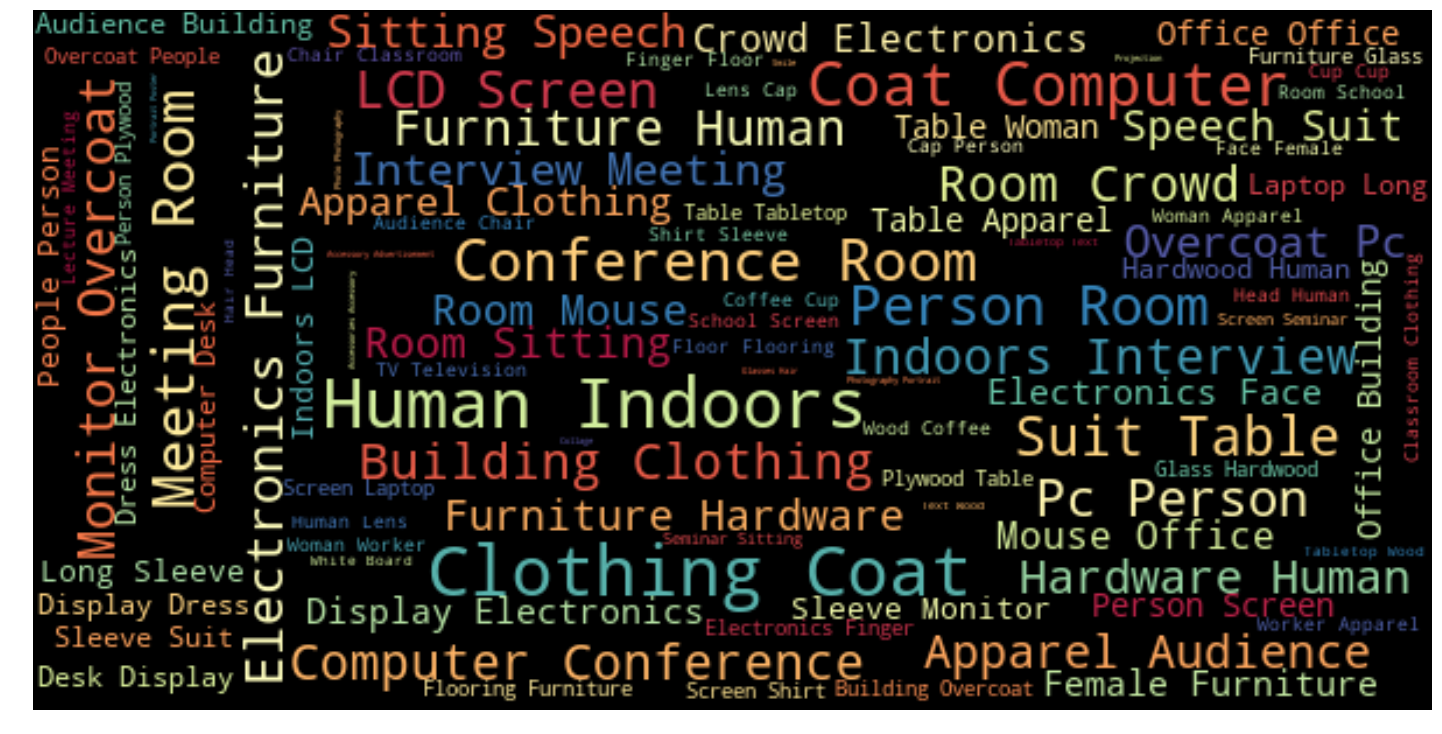

In [11]:
video_labels_wordcloud(text)

In [12]:
def video_labels_search(df, column, match):
    df_result = df[df[column].str.contains(match)]
    return df_result

In [16]:
video_labels_search(df, 'LabelName', 'Person')

,Timestamp,LabelName,Score,Instances,ParentsCount,Parents
20,0,Person,99.76,4,0,
46,166,Person,99.76,4,0,
72,375,Person,99.76,4,0,
98,583,Person,99.76,4,0,
125,792,Person,99.77,4,0,
151,959,Person,99.77,4,0,
176,1167,Person,99.77,4,0,
198,1376,Person,99.73,4,0,
215,1584,Person,99.69,4,0,
228,1793,Person,99.65,2,0,


In [15]:
video_labels_search(df, 'Parents', 'Computer')

,Timestamp,LabelName,Score,Instances,ParentsCount,Parents
15,0,Mouse,82.03,1,3,"Electronics, Hardware, Computer"
41,166,Mouse,83.93,1,3,"Electronics, Computer, Hardware"
67,375,Mouse,85.22,1,3,"Electronics, Computer, Hardware"
93,583,Mouse,87.57,1,3,"Electronics, Computer, Hardware"
119,792,Mouse,89.41,1,3,"Computer, Hardware, Electronics"
123,792,Pc,50.10,0,2,"Computer, Electronics"
146,959,Mouse,89.70,1,3,"Hardware, Electronics, Computer"
172,1167,Mouse,90.15,1,3,"Computer, Hardware, Electronics"
195,1376,Mouse,73.25,1,3,"Hardware, Computer, Electronics"
214,1584,Mouse,55.04,1,3,"Electronics, Hardware, Computer"
